In [1]:
import sys
import time
import datetime
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
%run util/define_auxiliary_functions.py
%run util/model_constructors.py

### Load the Raw Data

In [3]:
from platform import python_version
print(python_version())

3.8.3


In [4]:
sns.set()

COMPUTE_NEW = False
PRECOMPUTED_AVAILABLE = os.path.isfile("./data_raw.csv") and os.path.isfile("./data_global.csv") and os.path.isfile("./data_local.csv") and os.path.isfile("./data_auto.csv")

rs = np.random.RandomState(42)
root_dir = "data"

print("Precomputed calibrations available?", PRECOMPUTED_AVAILABLE)

Precomputed calibrations available? False


### Create/Load Global-, Local-, and Auto-Calibration Sets

In [5]:
pd.options.mode.chained_assignment = None

if COMPUTE_NEW or not PRECOMPUTED_AVAILABLE:
    dataset = load_complete_dataset(root_dir)
    
    # Add filerow and iteration information
    rows = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    rows = np.concatenate([rows for i in np.arange(dataset.shape[0] / 10)])
    dataset['filerow'] = rows

    # Identify iterations
    tmp_set = dataset.copy()
    tmp_set['iteration'] = dataset.apply(lambda x: 0 if not x.filename[-5].isnumeric() else int(x.filename[-5]), axis=1)
    tmp_set['filename'] = dataset.apply(lambda x: x.filename[:-4] if not x.filename[-5].isnumeric() else x.filename[:-5], axis=1)
    dataset = tmp_set.copy()
    del tmp_set
    
    dataset_scaled, global_calib_set, local_calib_set, auto_calib_set = compute_calibrations(
        dataset, root_dir
    )
    del dataset
else:
    dataset_scaled = pd.read_csv(os.path.join(root_dir, "data_raw.csv"), header=0)
    local_calib_set = pd.read_csv(os.path.join(root_dir, "data_local.csv"), header=0)
    global_calib_set = pd.read_csv(os.path.join(root_dir, "data_global.csv"), header=0)
    auto_calib_set = pd.read_csv(os.path.join(root_dir, "data_auto.csv"), header=0)

Saving calibrated sets...


In [6]:
feat_cols = [i for i in dataset_scaled.columns if 'electrode' in i]
calib_cols = [w.replace('setup', 'calib') for w in feat_cols]

print("Users in set:", dataset_scaled.subject.unique())
print("Amount of samples in set:", dataset_scaled.shape[0])

Users in set: ['C' 'A' 'B' 'F' 'E' 'D']
Amount of samples in set: 11840


In [7]:
from sklearn.model_selection import LeaveOneGroupOut

loss = 'sparse_categorical_crossentropy'
optimizer = tf.keras.optimizers.Adam()
BATCH_SIZE = 256
REPEATS = 1
EPOCHS = 100

results_df = pd.DataFrame()

models_to_train = [cnn1_model, cnn2_model, dual_branch_cnn3_dropout_2_model, single_branch_cnn6_model]

for calibration, dataset_calib in zip(['Raw', 'Global', 'Local', 'Auto'], [dataset_scaled, global_calib_set, local_calib_set, auto_calib_set]):
    print(">>> Training on %s data set" % calibration)
    for i, subject in enumerate(dataset_calib.query("subject=='E'").subject.unique()):
        group_kfold = LeaveOneGroupOut()

        num_split = group_kfold.get_n_splits(groups=dataset_calib.query("subject==@subject").session)

        for sess_num, (train_index, test_index) in enumerate(group_kfold.split(dataset_calib.query("subject==@subject"), groups=dataset_calib.query("subject==@subject").session)):
            train_set = dataset_calib.query("subject==@subject").iloc[train_index, :]
            test_set = dataset_calib.query("subject==@subject").iloc[test_index, :]
            
            print("With holdout session %d (train setup %d of %d)" % (test_set.session.unique(), sess_num+1, num_split))

            max_val = np.max(train_set[feat_cols].values)
            min_val = np.min(train_set[feat_cols].values)

            train_vals = (train_set[feat_cols].values - min_val)/(max_val - min_val)
            test_vals = (test_set[feat_cols].values - min_val)/(max_val - min_val)


            for mod_num, model_creator_fn in enumerate(models_to_train):
                for k in np.arange(REPEATS):
                    model = model_creator_fn()

                    if (calibration != 'Auto' and len(model.inputs) != 1) or (calibration == 'Auto' and len(model.inputs) != 2):
                        # Can't train dual input model on single input set
                        print("Skipping model '%s' for calibration '%s' (incompatible input configuration)" % (model.name, calibration))
                        continue
                    
                    if calibration != 'Auto':
                        # Single In
                        data_train = tf.data.Dataset.from_tensor_slices(
                            (train_vals.reshape(-1, 16, 16, 1), train_set.label.values)
                        )
                        data_test = tf.data.Dataset.from_tensor_slices(
                            (test_vals.reshape(-1, 16, 16, 1), test_set.label.values)
                        )
                        
                    else:
                        # Dual In
                        data_train = tf.data.Dataset.from_tensor_slices((
                            (
                                (train_set[feat_cols].values / np.max(train_set[feat_cols].values)).reshape(-1, 16, 16, 1), 
                                (train_set[calib_cols].values / np.max(train_set[feat_cols].values)).reshape(-1, 16, 16, 1)
                            ), 
                            train_set.label.values
                        ))

                        data_test = tf.data.Dataset.from_tensor_slices((
                            (
                                (test_set[feat_cols].values / np.max(train_set[feat_cols].values)).reshape(-1, 16, 16, 1),
                                (test_set[calib_cols].values / np.max(train_set[feat_cols].values)).reshape(-1, 16, 16, 1)
                            ),
                            test_set.label.values
                        ))

                    data_train = data_train.cache()
                    data_test = data_test.cache()

                    data_train = data_train.batch(BATCH_SIZE, drop_remainder=False)
                    data_test = data_test.batch(BATCH_SIZE, drop_remainder=False)

                    model.compile(
                        loss=loss, 
                        optimizer=optimizer, 
                        metrics=['accuracy']
                    )

                    hist = model.fit(
                        x=data_train,
                        validation_data=(data_test),
                        shuffle=True,
                        epochs=EPOCHS,
                        verbose=0,
                    )

                    results_df = results_df.append(pd.DataFrame({
                        'best_val_accuracy': np.max(hist.history["val_accuracy"]),
                        'best_val_loss': np.min(hist.history["val_loss"]),
                        'best_accuracy': np.max(hist.history["accuracy"]),
                        'best_loss': np.min(hist.history["loss"]),
                        'history': hist,
                        'trial': k,
                        'holdout_session': test_set.session.unique(),
                        'batch_size': BATCH_SIZE,
                        'calibration': calibration,
                        'subject': subject,
                        'model': model.name,
                        }))
                    print("\t ... done with trial [%d/%d] for model [%d/%d]" % (k+1, REPEATS, mod_num+1, len(models_to_train)))

>>> Training on Raw data set
With holdout session 1 (train setup 1 of 8)
	 ... done with trial [1/1] for model [1/4]
	 ... done with trial [1/1] for model [2/4]
Skipping model 'dual-CNN3-dual-branch-dropout-2' for calibration 'Raw' (incompatible input configuration)
Skipping model 'dual-CNN6-single-branch' for calibration 'Raw' (incompatible input configuration)
With holdout session 2 (train setup 2 of 8)
	 ... done with trial [1/1] for model [1/4]
	 ... done with trial [1/1] for model [2/4]
Skipping model 'dual-CNN3-dual-branch-dropout-2' for calibration 'Raw' (incompatible input configuration)
Skipping model 'dual-CNN6-single-branch' for calibration 'Raw' (incompatible input configuration)
With holdout session 3 (train setup 3 of 8)
	 ... done with trial [1/1] for model [1/4]
	 ... done with trial [1/1] for model [2/4]
Skipping model 'dual-CNN3-dual-branch-dropout-2' for calibration 'Raw' (incompatible input configuration)
Skipping model 'dual-CNN6-single-branch' for calibration 'Raw

### Plot Model Metrics

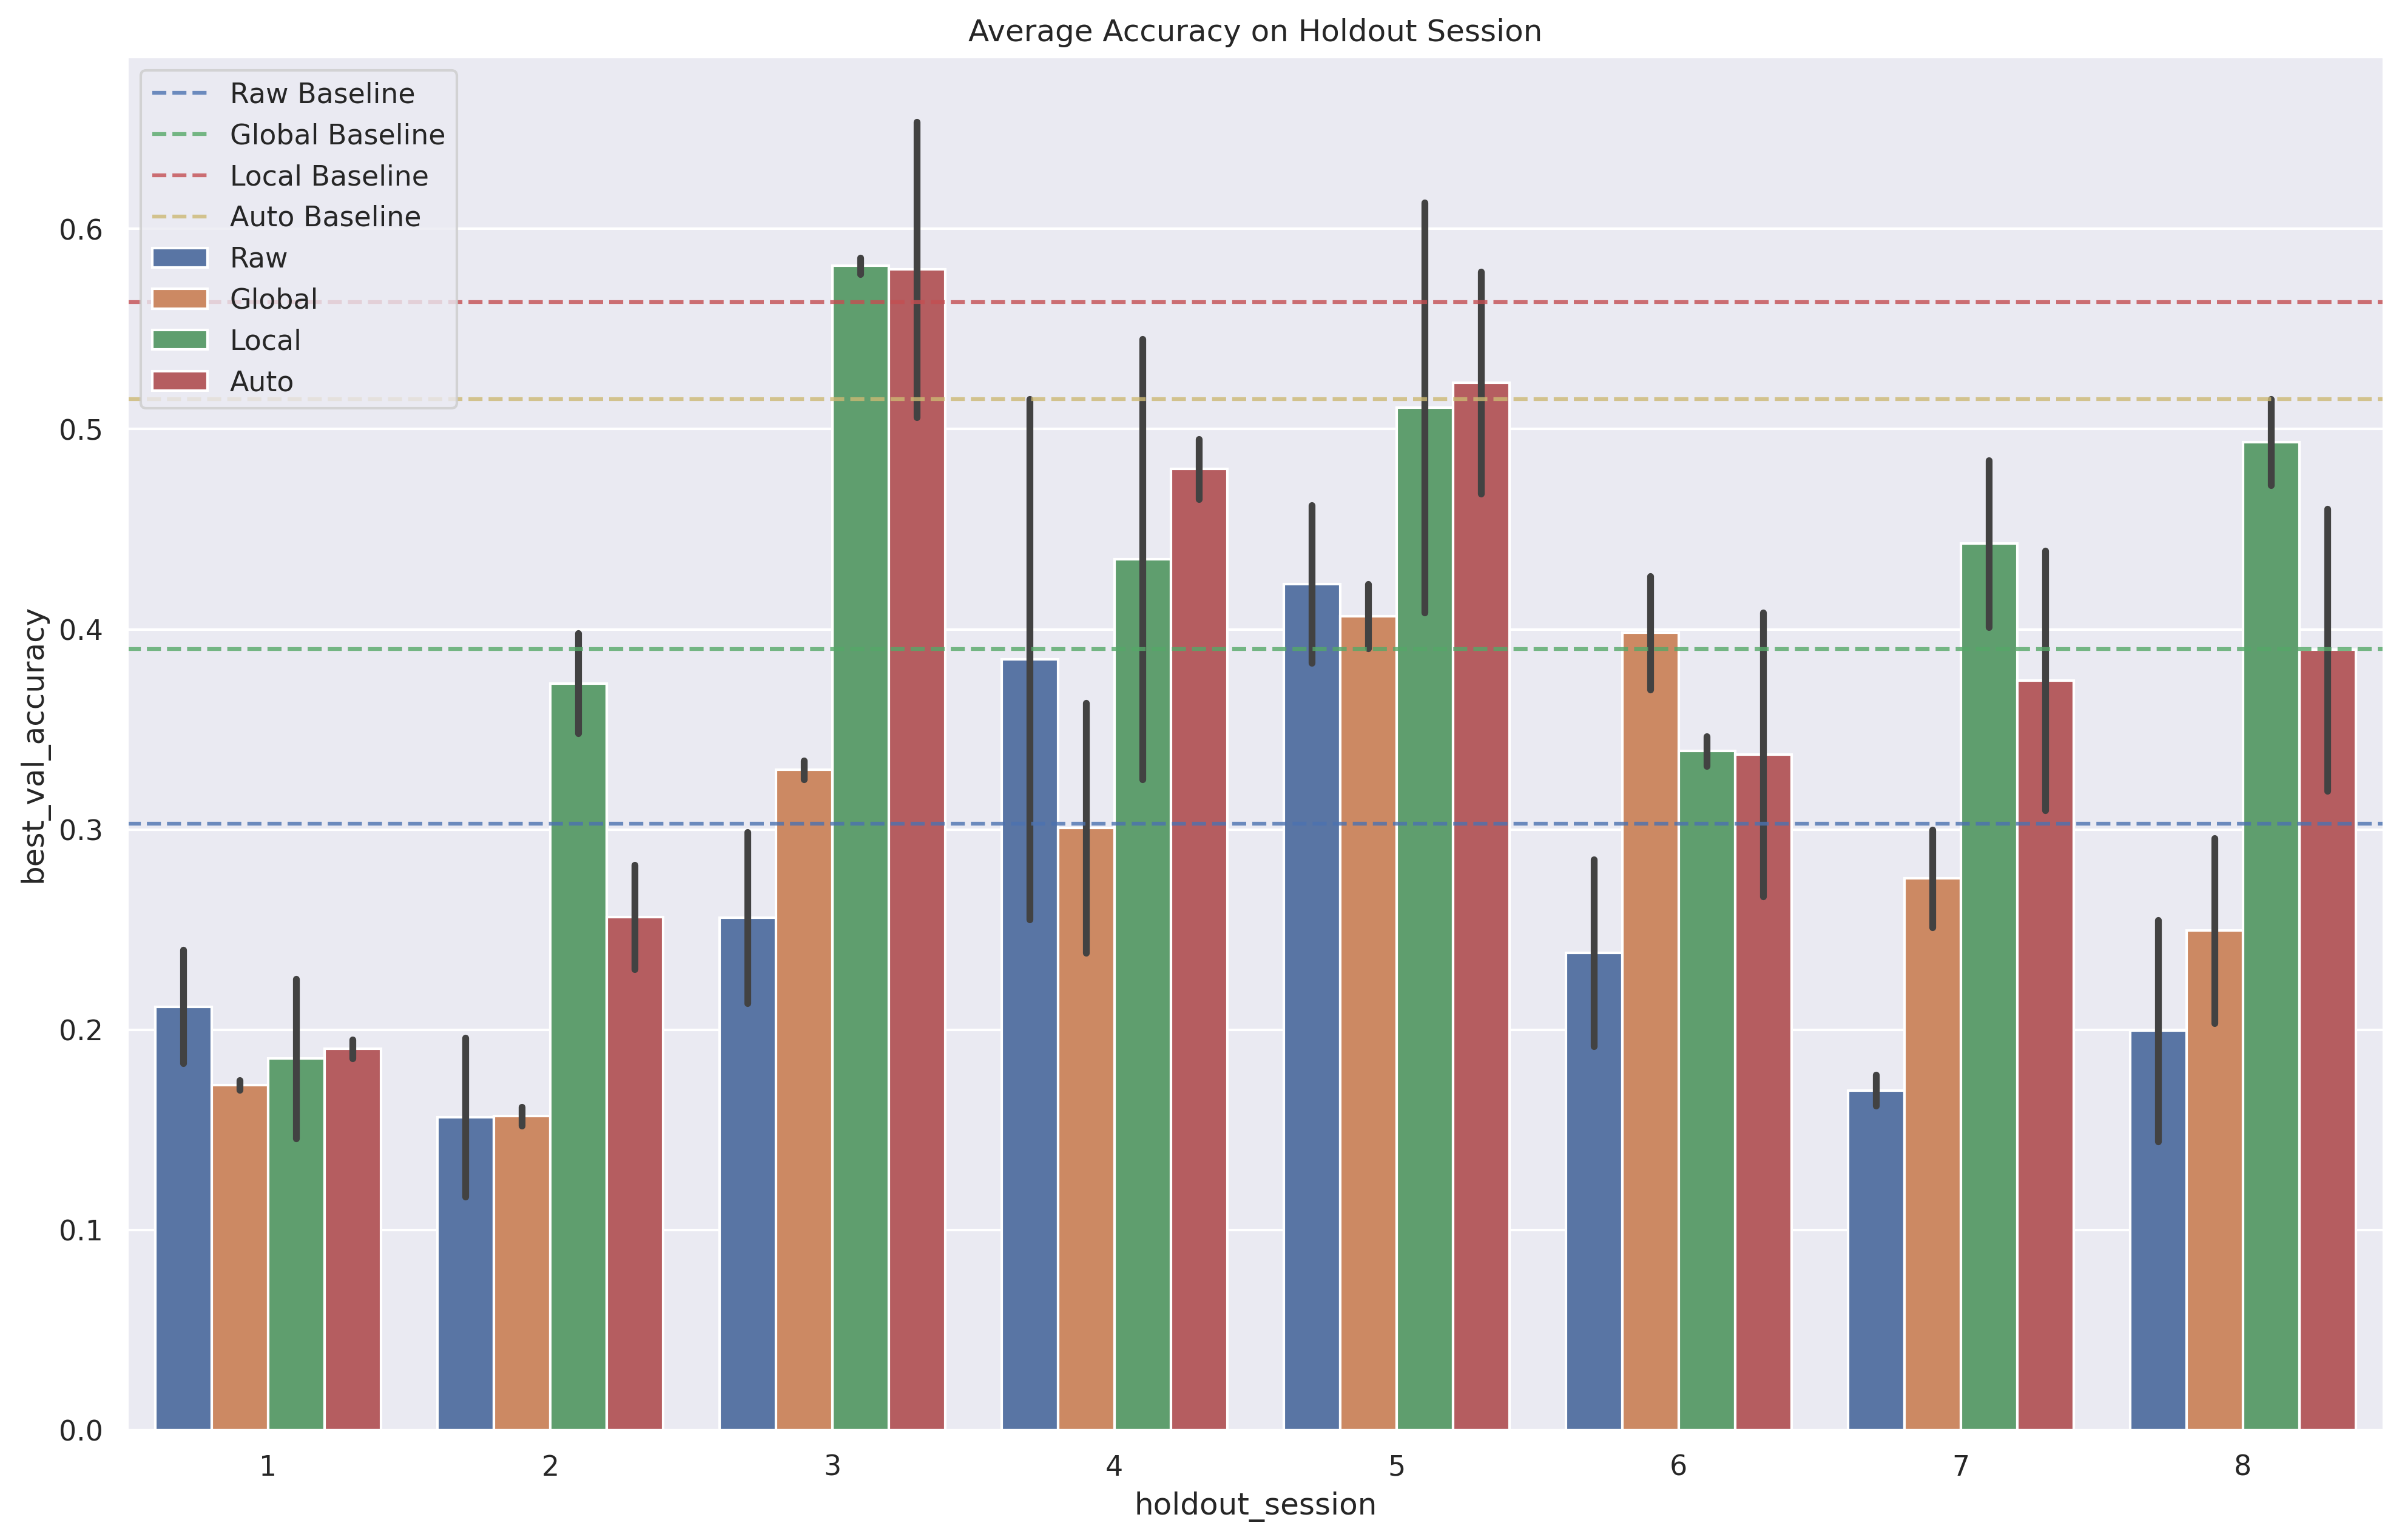

In [8]:
fig, ax = plt.subplots(figsize=(16,10), dpi=300)
sns.barplot(
    x='holdout_session', 
    y='best_val_accuracy', 
    hue='calibration', 
    data=results_df,
    ci=95,
)

ax.axhline(y=0.3028, color='b', alpha=0.8, linestyle='--', label="Raw Baseline")
ax.axhline(y=0.3901, color='g', alpha=0.8, linestyle='--', label="Global Baseline")
ax.axhline(y=0.5634, color='r', alpha=0.8, linestyle='--', label="Local Baseline")
ax.axhline(y=0.5151, color='y', alpha=0.8, linestyle='--', label="Auto Baseline")

ax.set_title("Average Accuracy on Holdout Session")

ax.legend();

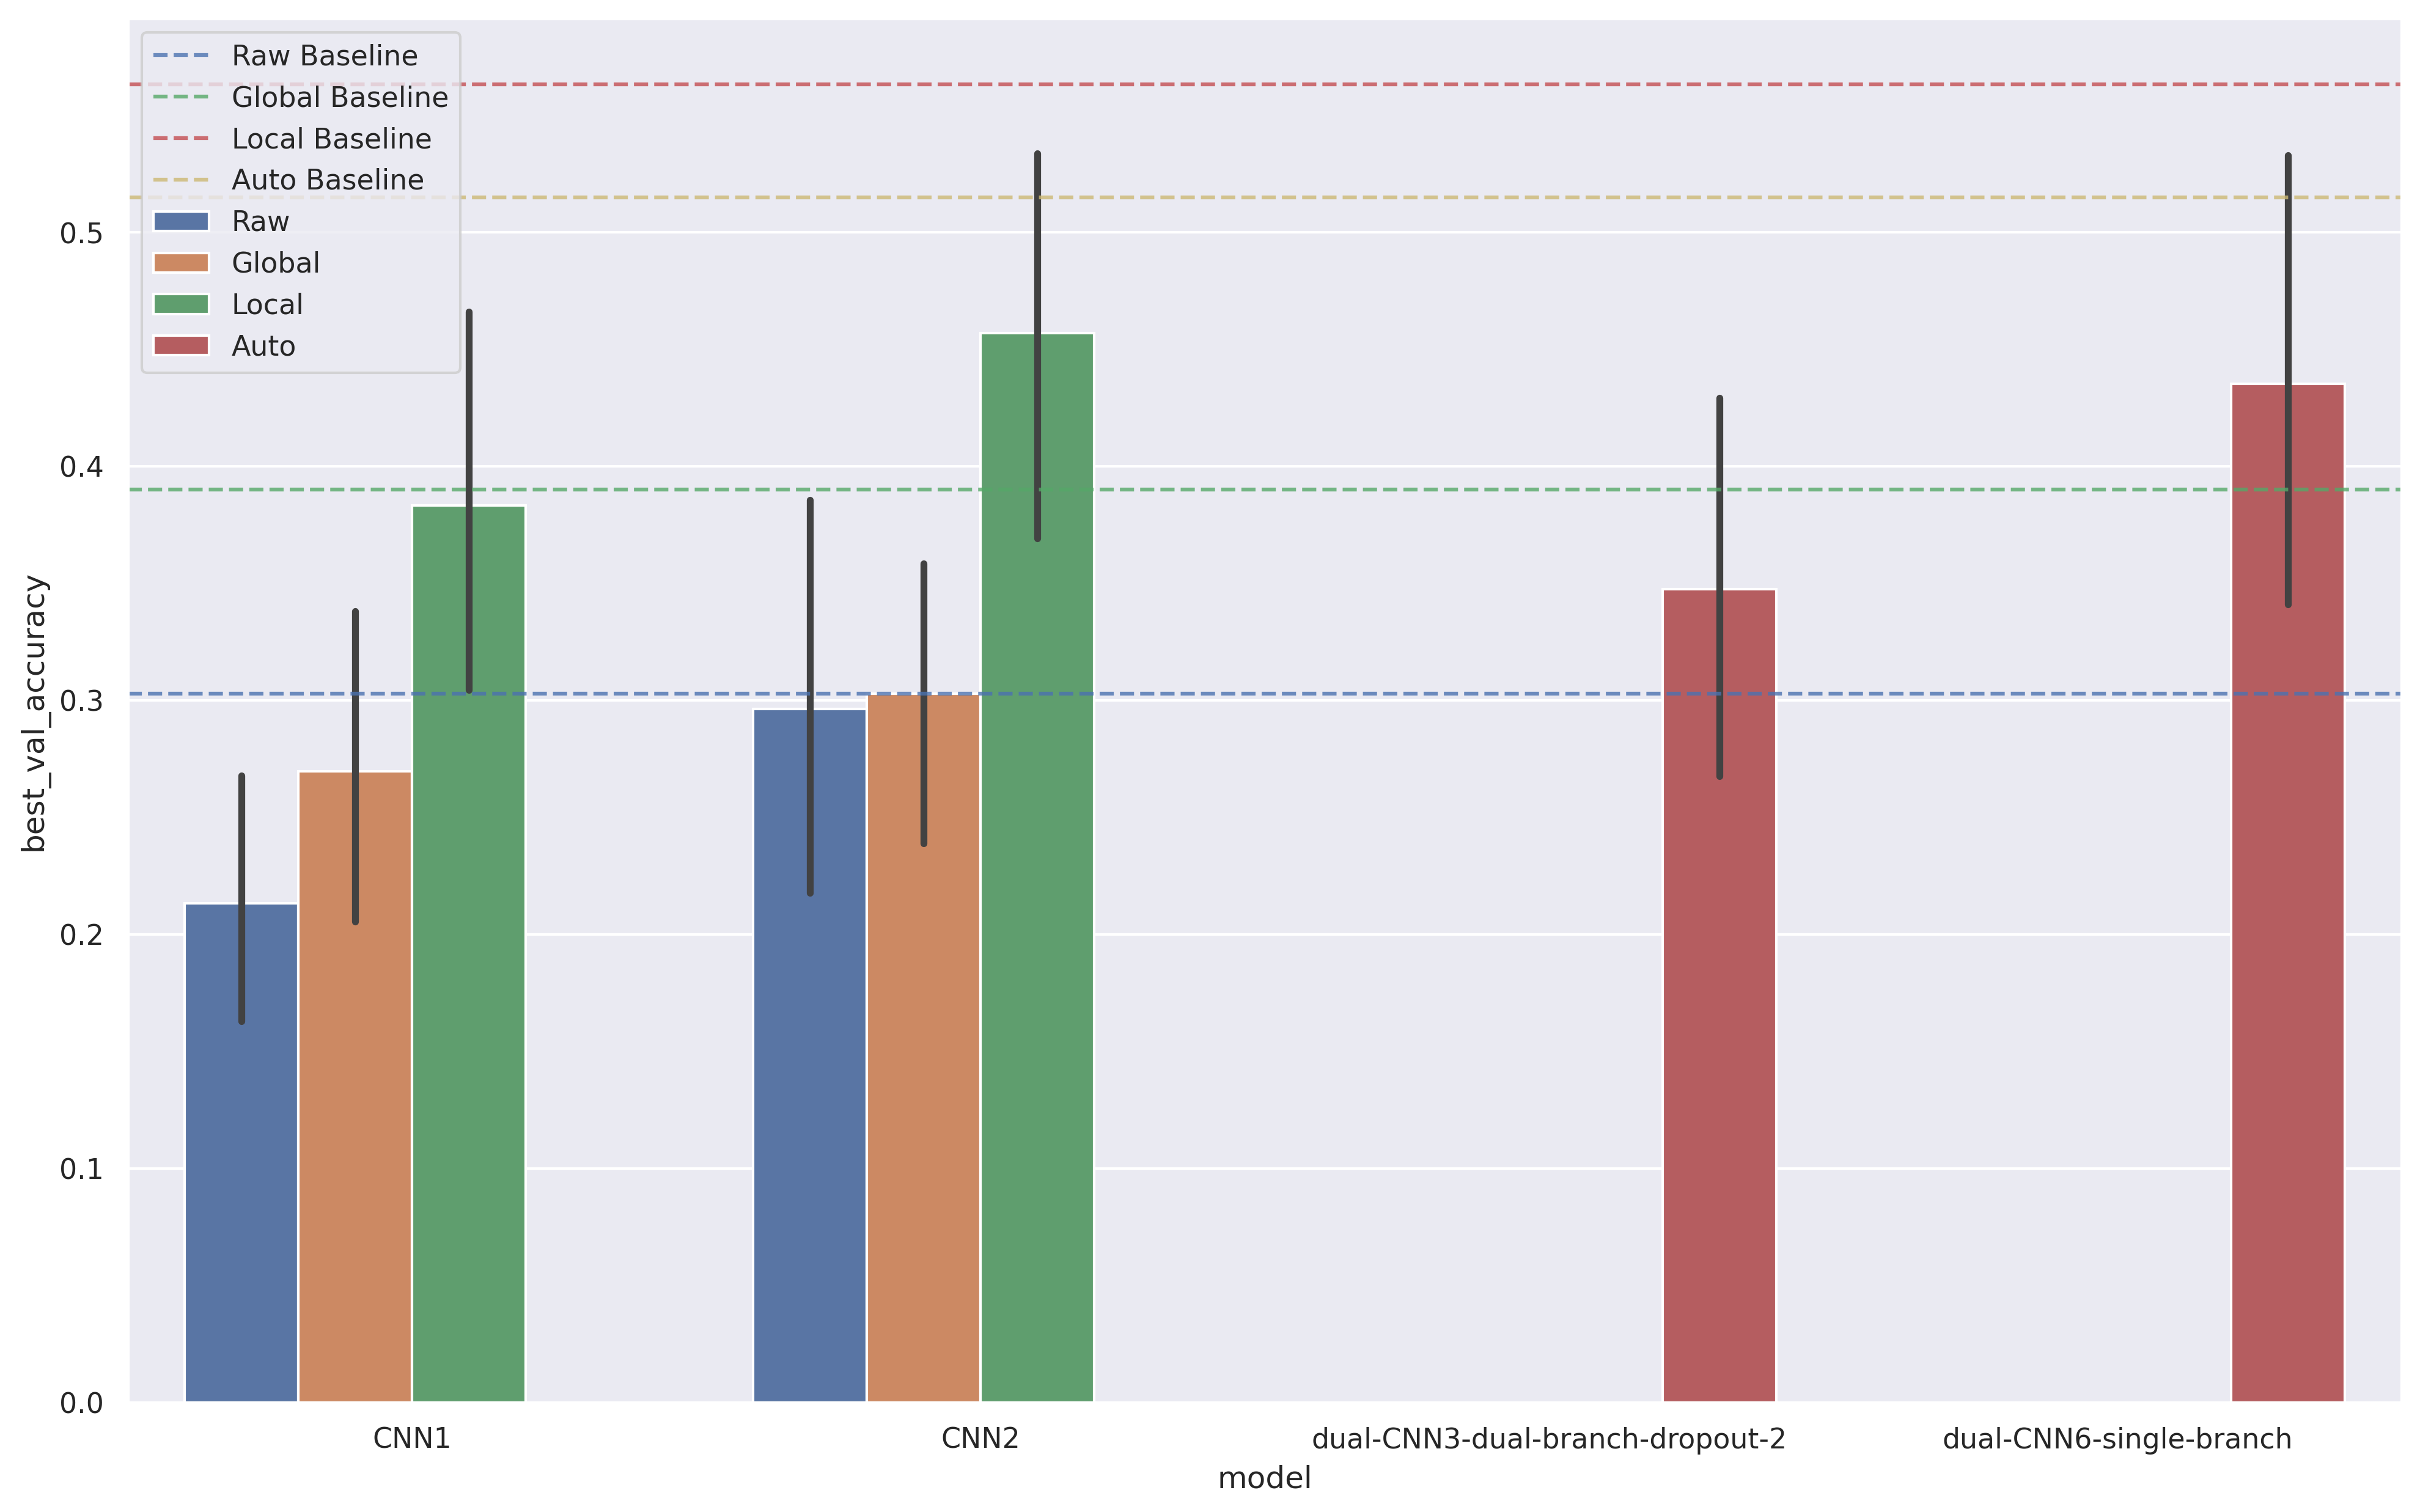

In [9]:
fig, ax = plt.subplots(figsize=(16,10), dpi=300)
g = sns.barplot(
    x='model', 
    y='best_val_accuracy',
    hue='calibration',
    data=results_df,
    ci=95,
)

#g.set_xticklabels(rotation=45)

ax.axhline(y=0.3028, color='b', alpha=0.8, linestyle='--', label="Raw Baseline")
ax.axhline(y=0.3901, color='g', alpha=0.8, linestyle='--', label="Global Baseline")
ax.axhline(y=0.5634, color='r', alpha=0.8, linestyle='--', label="Local Baseline")
ax.axhline(y=0.5151, color='y', alpha=0.8, linestyle='--', label="Auto Baseline")

ax.legend();

### Plot History of a Single Run

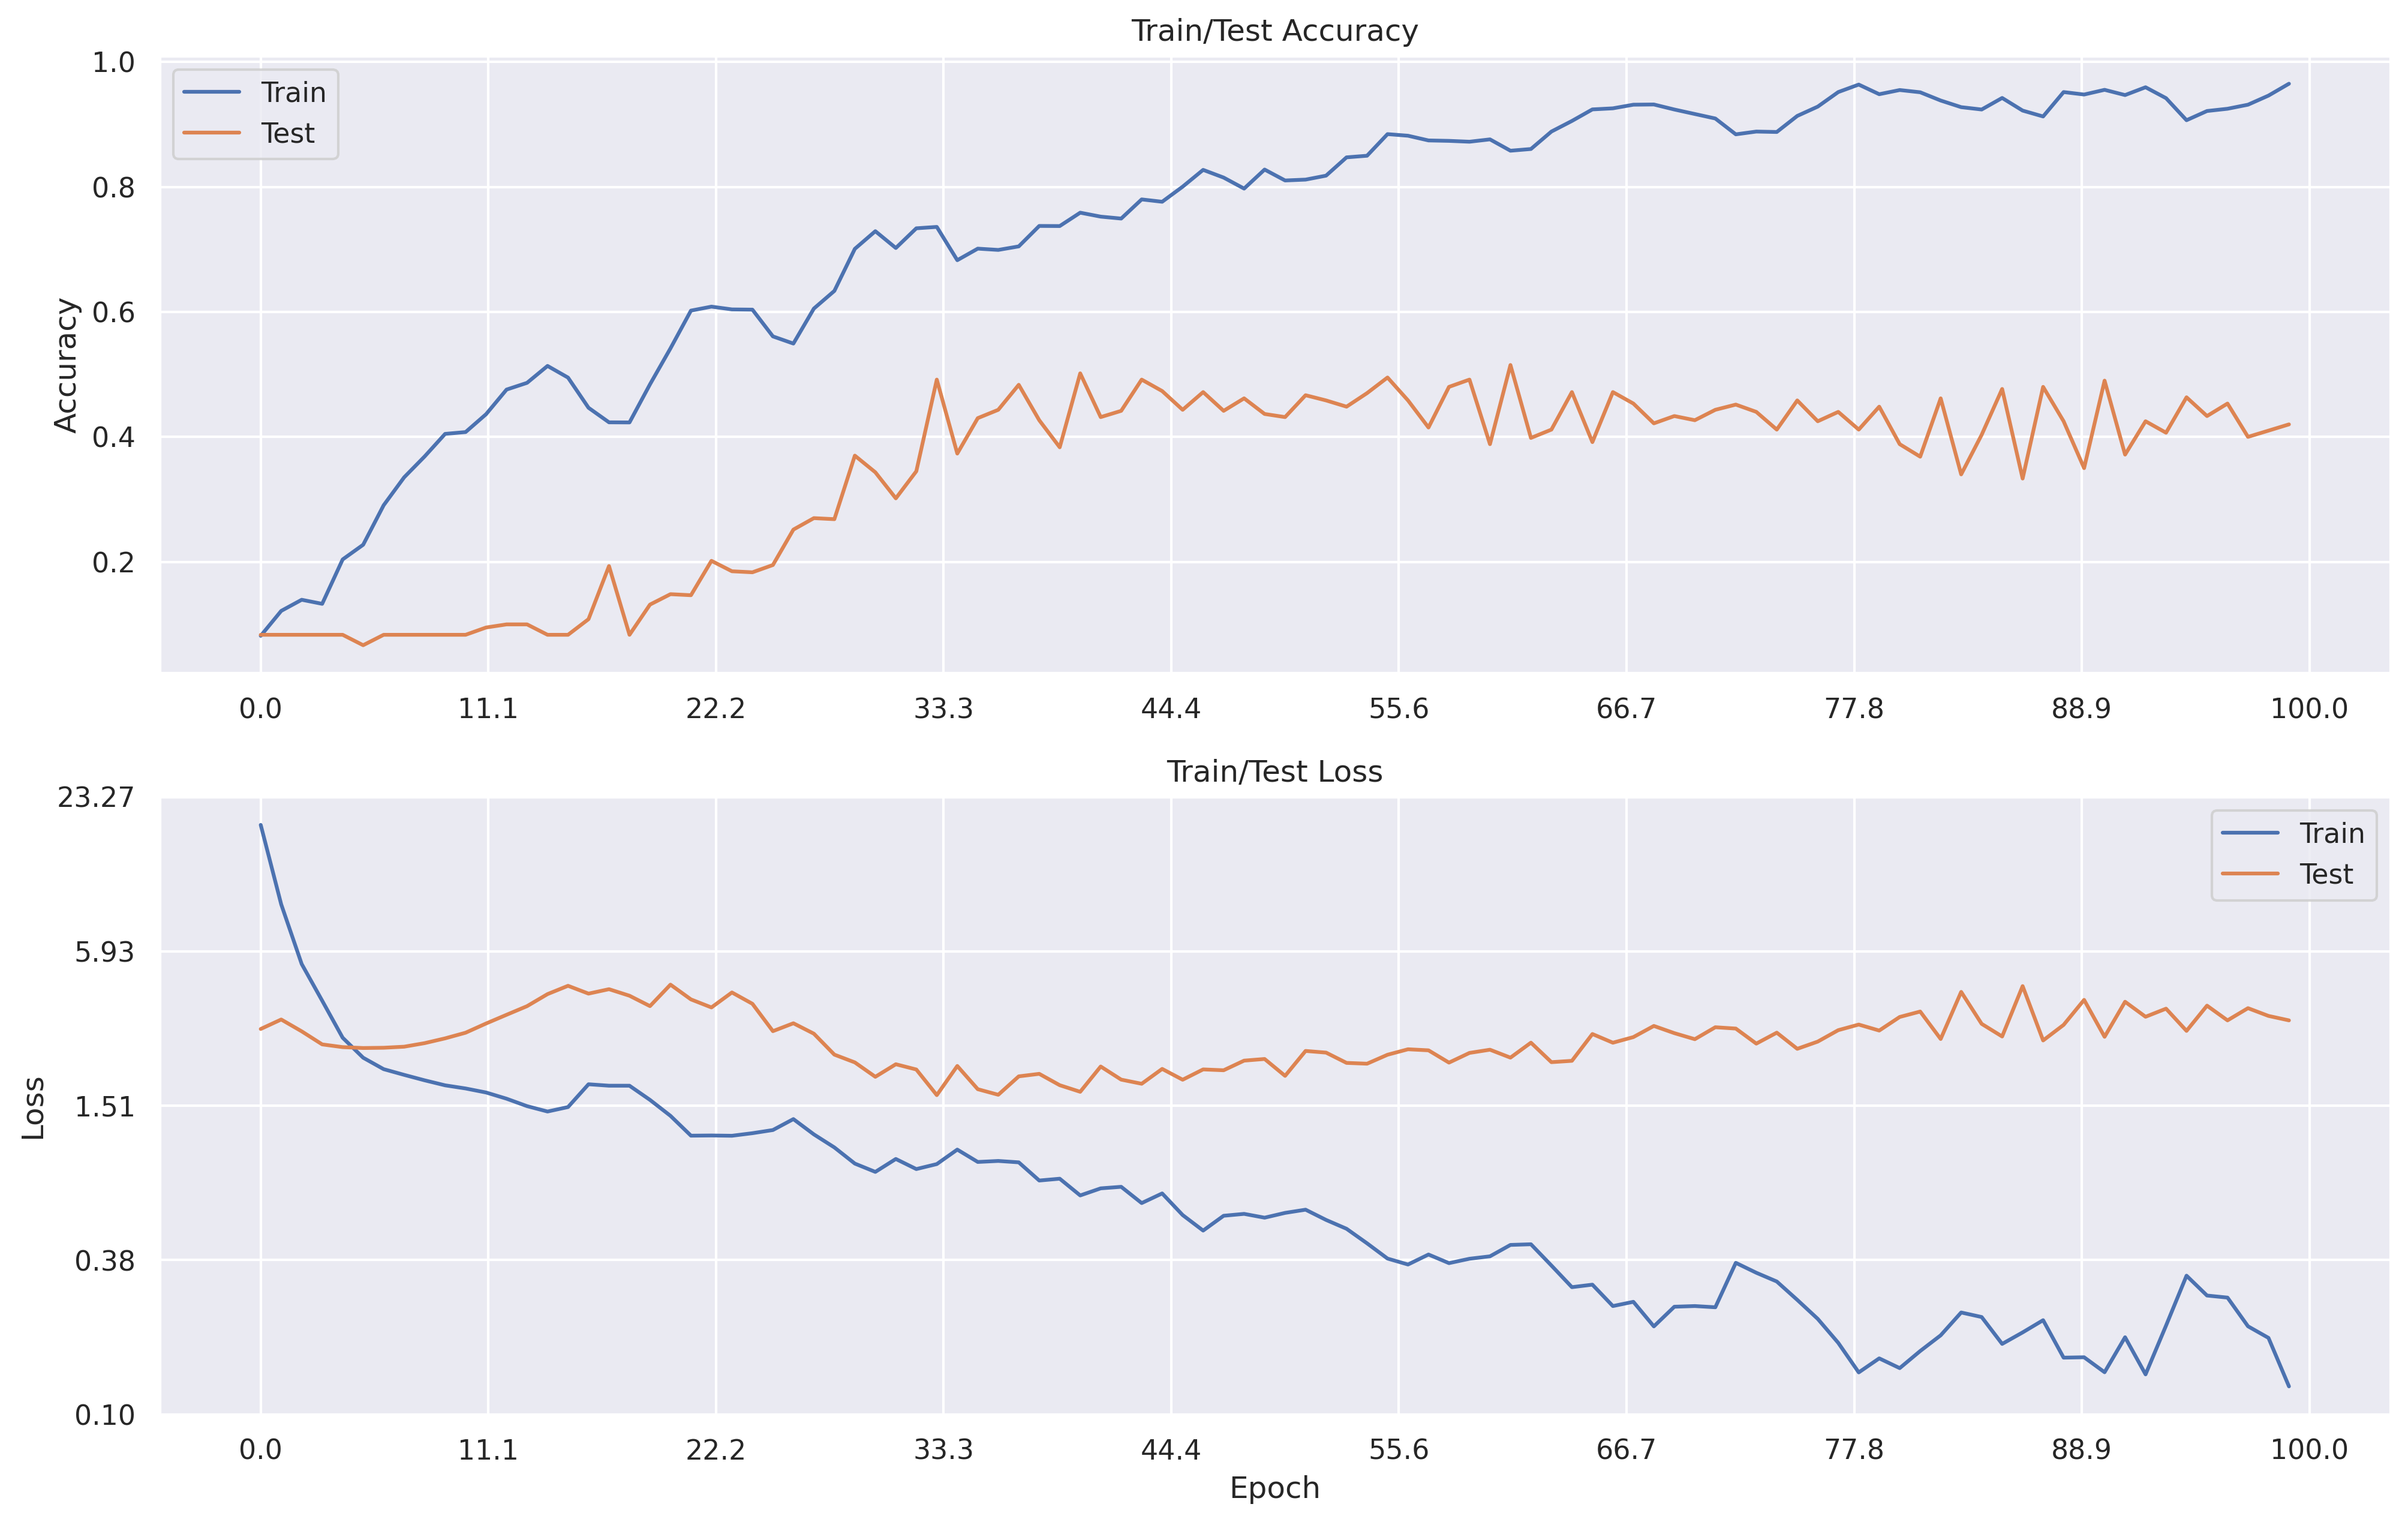

In [10]:
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(16,10), dpi=300)

plot_df = results_df.query("calibration=='Raw' and holdout_session=='4' and trial=='0' and model=='CNN2'")

ax1.set_title("Train/Test Accuracy")
ax1.plot(
    plot_df.history.values[0].history['accuracy'],
    label="Train",
)
ax1.plot(
    plot_df.history.values[0].history['val_accuracy'],
    label="Test",
)
ax1.legend()
ax1.set_xticks(np.linspace(0, 100, 10))
ax1.set_ylabel("Accuracy")

ax2.set_title("Train/Test Loss")
ax2.plot(
    plot_df.history.values[0].history['loss'],
    label="Train",
)
ax2.plot(
    plot_df.history.values[0].history['val_loss'],
    label="Test",
)
ax2.set_yscale("log")
ax2.legend()

ax2.yaxis.set_major_formatter(ScalarFormatter())
ax2.yaxis.set_minor_locator(ticker.NullLocator())

limits = ax2.yaxis.axes.get_ylim()
ax2.set_xticks(np.linspace(0, 100, 10))
ax2.set_yticks(np.geomspace(limits[0], limits[1], num=5))
ax2.set_ylabel("Loss")
ax2.set_xlabel("Epoch");